# Video pipeline with Yolo + Resnet Model

In [59]:
import pandas as pd
import os
import sys
from pprint import PrettyPrinter
import matplotlib.pyplot as plt
from typing import Dict, List
import numpy as np

pp = PrettyPrinter(indent=4)
from barazmoon.twitter import twitter_workload_generator

# get an absolute path to the directory that contains parent files
__file__ = globals()["_dh"][0]
project_dir = __file__ = globals()["_dh"][0]
sys.path.append(os.path.normpath(os.path.join(project_dir, "..", "..", "..")))

from experiments.utils.constants import FINAL_RESULTS_PATH
from experiments.utils.parser import AdaptationParser
from experiments.utils.drawing import draw_temporal, draw_cumulative

In [60]:
series = 404
series_path = os.path.join(FINAL_RESULTS_PATH, "series", str(series))

loader = AdaptationParser(
    series_path=series_path,
    model_name="video",
    type_of="router_pipeline",  # pipeline | router_pipeline | router_queue_pipeline
)

In [61]:
configs = loader.load_configs()
for config_name, config in configs.items():
    print(f"File name: {config_name}")
    pp.pprint(config)
accuracy_method = config["accuracy_method"]
adaptation_interval = config["adaptation_interval"]
try:
    simulation_mode = config["simulation_mode"]
except KeyError:
    simulation_mode = False

File name: 0.yaml
{   'accuracy_method': 'sum',
    'adaptation_interval': 20,
    'allocation_mode': 'base',
    'alpha': 10,
    'backup_predictor_duration': 2,
    'backup_predictor_type': 'max',
    'baseline_mode': 'switch',
    'batching_cap': 64,
    'benchmark_duration': 1,
    'beta': 0,
    'central_queue': True,
    'debug_mode': False,
    'distrpution_time': 30,
    'drop_limit': 10,
    'gamma': 10,
    'initial_active_model': [   'facebook-s2t-small-librispeech-asr',
                                'deepset-roberta-base-squad2'],
    'initial_batch': [1, 1],
    'initial_cpu_allocation': [1, 1],
    'initial_replica': [20, 10],
    'latency_margin': 100,
    'metadata': 'with throughput margin of 50',
    'mode': 'exponential',
    'model_name': ['audio', 'nlp-qa'],
    'monitoring_duration': 2,
    'nodes': [   {   'cpu_request': '1',
                     'data_type': 'audio',
                     'max_batch_size': '1',
                     'max_batch_time': '1',
      

In [62]:
# load the sent workload
workload_type = config["workload_type"]
if workload_type == "twitter":
    workload_config = config["workload_config"][0]
    start = workload_config["start"]
    end = workload_config["end"]
    damping_factor = workload_config["damping_factor"]
    sent_load = twitter_workload_generator(
        days=f"{start}-{end}", damping_factor=damping_factor
    )
elif workload_type == "static":
    sent_load = [10] * 1800

In [63]:
# key_config_df = loader.loader.key_config_mapper()
# display(key_config_df)
# key_config_df.columns
if not simulation_mode:
    results = loader.result_processing()

In [64]:
adaptation_log = loader.load_adaptation_log()

In [65]:
series_changes = loader.series_changes(
    adaptation_log=adaptation_log
)  # TODO go inside this

## Comparing Predicted Load with the Recieved Load

[6, 5, 4, 5, 5, 5, 4, 5, 5, 5, 5, 5, 4, 5, 6, 6, 6, 4, 6, 5, 4, 5, 6, 5, 6, 5, 5, 4, 4, 7, 4, 3, 6, 5, 4, 4, 3, 6, 4, 6, 5, 4, 4, 6, 5, 6, 5, 5, 4, 5, 5, 4, 4, 6, 5, 3, 5, 5, 4, 5, 5, 7, 6, 6, 4, 5, 5, 4, 5, 4, 6, 6, 4, 6, 4, 5, 4, 4, 5, 5, 5, 5, 5, 5, 6, 4, 6, 6, 5, 5, 4, 5, 5, 4, 5, 4, 4, 6, 4, 6, 5, 6, 6, 7, 5, 5, 5, 5, 6, 4, 6, 4, 4, 5, 5, 6, 6, 3, 5, 5, 7, 4, 5, 4, 6, 5, 5, 5, 6, 6, 5, 5, 4, 4, 5, 5, 5, 5, 7, 6, 4, 4, 5, 4, 7, 7, 6, 5, 5, 4, 5, 5, 6, 6, 4, 4, 4, 4, 5, 5, 6, 5, 5, 5, 6, 4, 4, 5, 5, 5, 4, 4, 6, 5, 4, 5, 4, 5, 7, 5, 5, 5, 6, 6, 6, 5, 7, 5, 5, 5, 4, 5, 7, 4, 6, 5, 6, 6, 7, 5, 5, 6, 6, 4, 5, 4, 4, 5, 6, 5, 5, 5, 4, 5, 4, 6, 5, 7, 5, 7, 5, 5, 5, 5, 6, 4, 4, 5, 5, 4, 4, 6, 5, 4, 4, 5, 6, 6, 4, 3, 5, 3, 5, 5, 7, 5, 4, 5, 7, 5, 4, 4, 4, 4, 6, 4, 4, 6, 4, 3, 6, 5, 6, 5, 5, 4, 4, 6, 5, 4, 6, 5, 6, 5, 6, 7, 7, 5, 5, 4, 7, 6, 6, 5, 4, 6, 6, 4, 6, 5, 4, 4, 4, 5, 5, 5, 3, 5, 5, 6, 8, 10, 7, 6, 5, 6, 6, 5, 6, 6, 4, 6, 6, 3, 7, 6, 6, 4, 6, 6, 5, 6, 6, 3, 7, 4, 5, 6, 6, 5, 5, 5, 5,

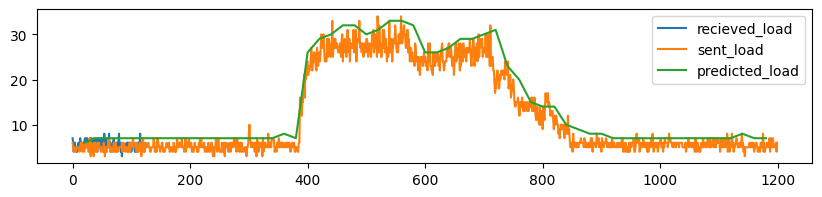

In [66]:
recieved_load = series_changes["recieved_load"]
predicted_load = series_changes["predicted_load"]
# recieved_load = [int(item) for item in recieved_load if item != 0]
recieved_load_x = [x for x in range(0, len(recieved_load))]
sent_load_x = [x for x in range(0, len(sent_load))]
predicted_load_x = series_changes["time_interval"]

print(sent_load)
print(recieved_load)

print(len(sent_load))
print(len(recieved_load))
plt.figure(figsize=(10, 2))
plt.plot(recieved_load_x, recieved_load, label="recieved_load")
plt.plot(sent_load_x, sent_load, label="sent_load")
plt.plot(predicted_load_x, predicted_load, label="predicted_load")
# TODO add predicted reference load here
plt.legend()
plt.show()

## Replica Changes
1. Total
2. Per node

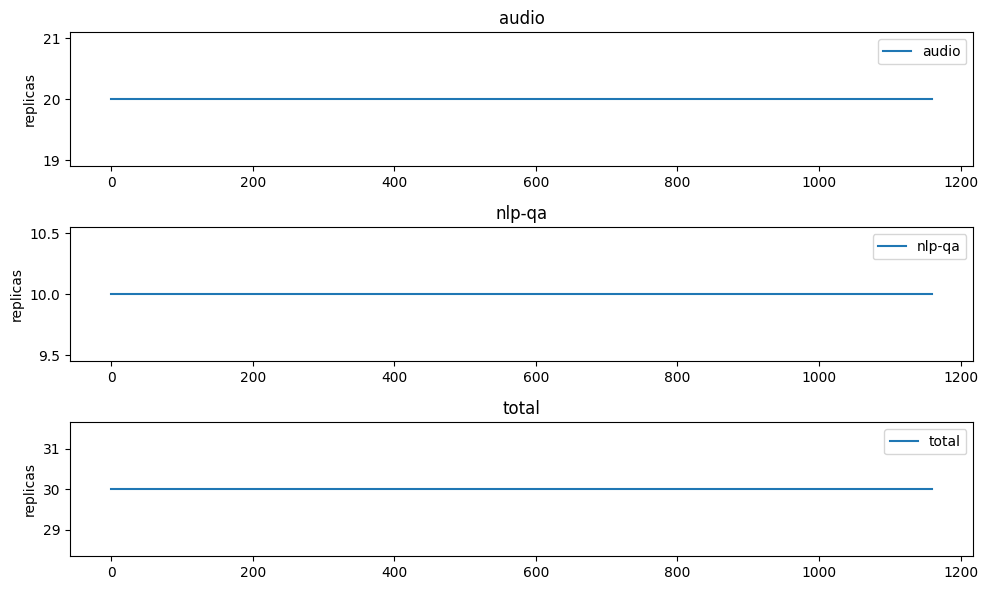

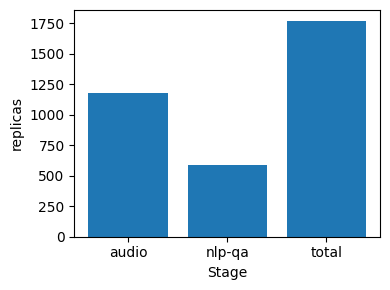

In [67]:
replica_changes = {}
nodes = []
for node_name, metrics in series_changes["nodes"].items():
    replica_changes[node_name] = metrics["replicas"]
    nodes.append(node_name)
replica_changes["total"] = [sum(x) for x in zip(*replica_changes.values())]
ylabel = "replicas"
draw_temporal(replica_changes, adaptation_interval, ylabel=ylabel)
draw_cumulative(replica_changes, ylabel=ylabel)

## Per Container Core changes
1. Total
2. Per Node

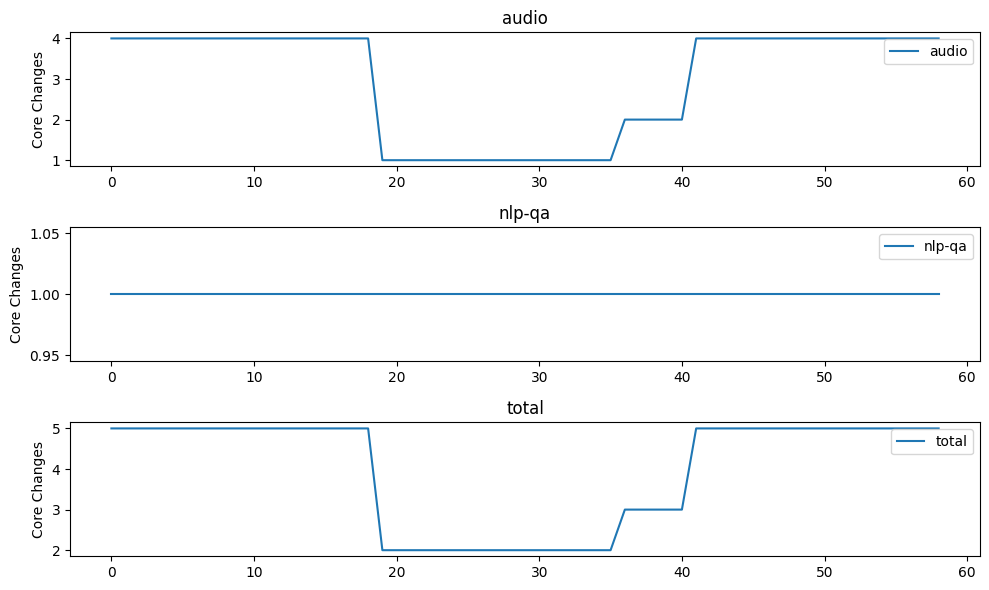

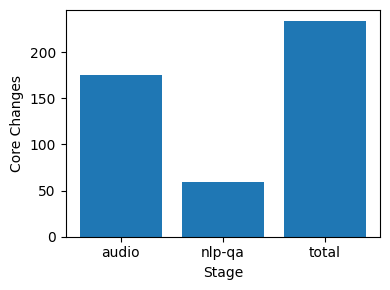

In [68]:
core_changes = {}
nodes = []
for node_name, metrics in series_changes["nodes"].items():
    core_changes[node_name] = metrics["cpu"]
    nodes.append(node_name)
core_changes["total"] = [sum(x) for x in zip(*core_changes.values())]
ylabel = "Core Changes"
draw_temporal(core_changes, ylabel=ylabel)
draw_cumulative(core_changes, ylabel=ylabel)

## Total core changes
replica * cores for each stage
1. Total
2. Per Node

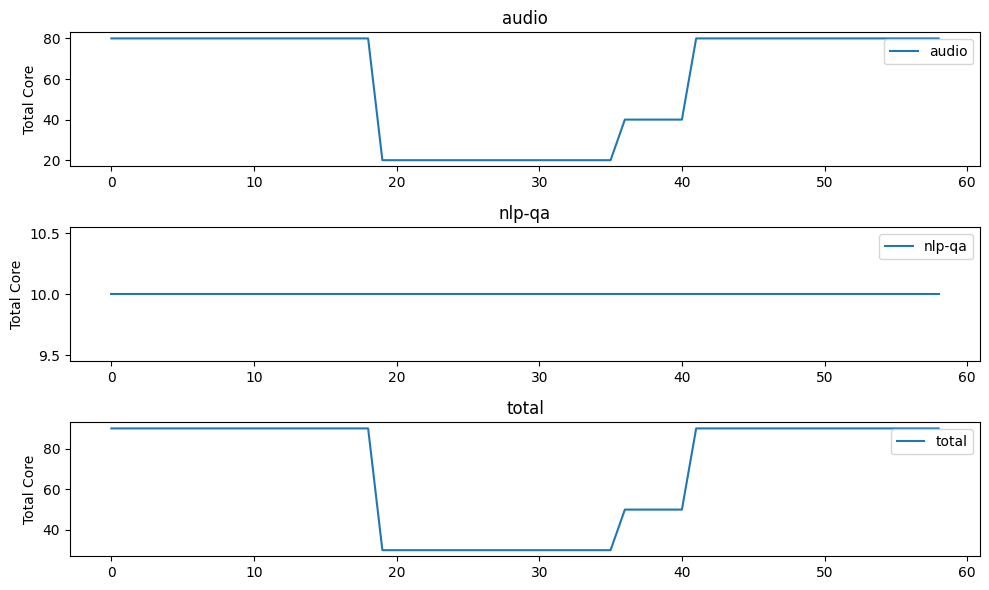

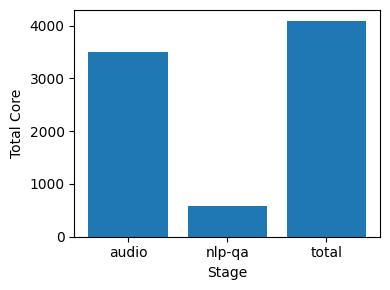

In [69]:
# TODO fix it
total_core_changes = {}
for key in replica_changes.keys():
    if key != "total":
        total_core_changes[key] = [
            x * y for x, y in zip(replica_changes[key], core_changes[key])
        ]
total = np.zeros(len(list(total_core_changes.values())[0]))
for key, series_value in total_core_changes.items():
    total += np.array(series_value)
total_core_changes["total"] = total
ylabel = "Total Core"
draw_temporal(total_core_changes, ylabel=ylabel)
draw_cumulative(total_core_changes, ylabel=ylabel)

## Accuracy Changes

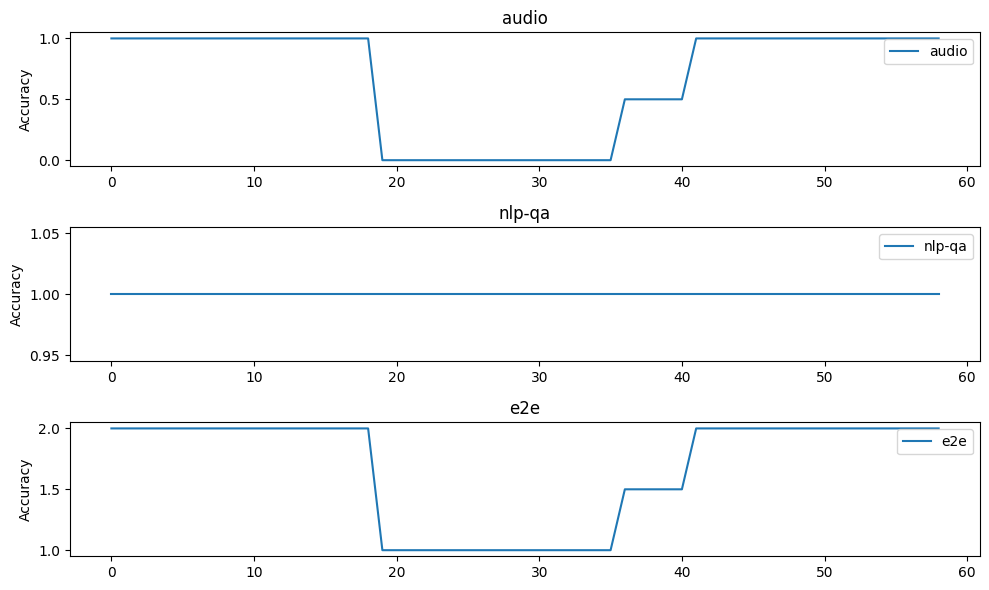

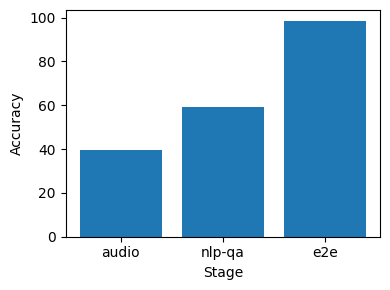

In [70]:
accuracy_changes = {}
nodes = []
for node_name, metrics in series_changes["nodes"].items():
    accuracy_changes[node_name] = metrics["accuracy"]
    nodes.append(node_name)
# replica_changes['total'] = []
if accuracy_method == "sum":
    accuracy_changes["e2e"] = [sum(x) for x in zip(*accuracy_changes.values())]
ylabel = "Accuracy"
draw_temporal(accuracy_changes, ylabel=ylabel)
draw_cumulative(accuracy_changes, ylabel=ylabel)

## Batching Changes

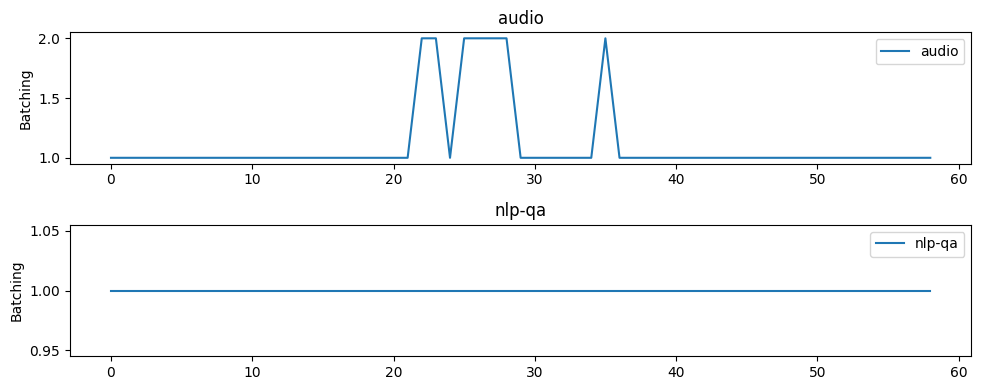

In [71]:
batching_changes = {}
nodes = []
for node_name, metrics in series_changes["nodes"].items():
    batching_changes[node_name] = metrics["batch"]
    nodes.append(node_name)
ylabel = "Batching"
draw_temporal(batching_changes, ylabel=ylabel)
# draw_cumulative(batching_changes)

# Expected Throughput

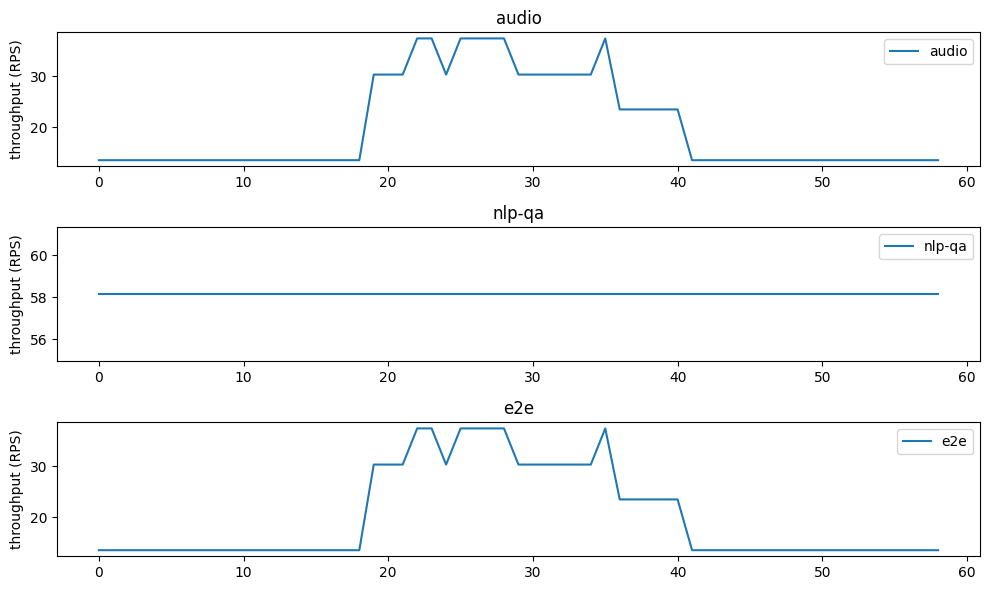

In [72]:
throughput_changes = {}
nodes = []
for node_name, metrics in series_changes["nodes"].items():
    throughput_changes[node_name] = metrics["throughput"]
    nodes.append(node_name)
# replica_changes['total'] = []
ylabel = "throughput (RPS)"
throughput_changes["e2e"] = [min(x) for x in zip(*throughput_changes.values())]
draw_temporal(throughput_changes, ylabel=ylabel)
# draw_cumulative(throughput_changes)

## Expected Latency

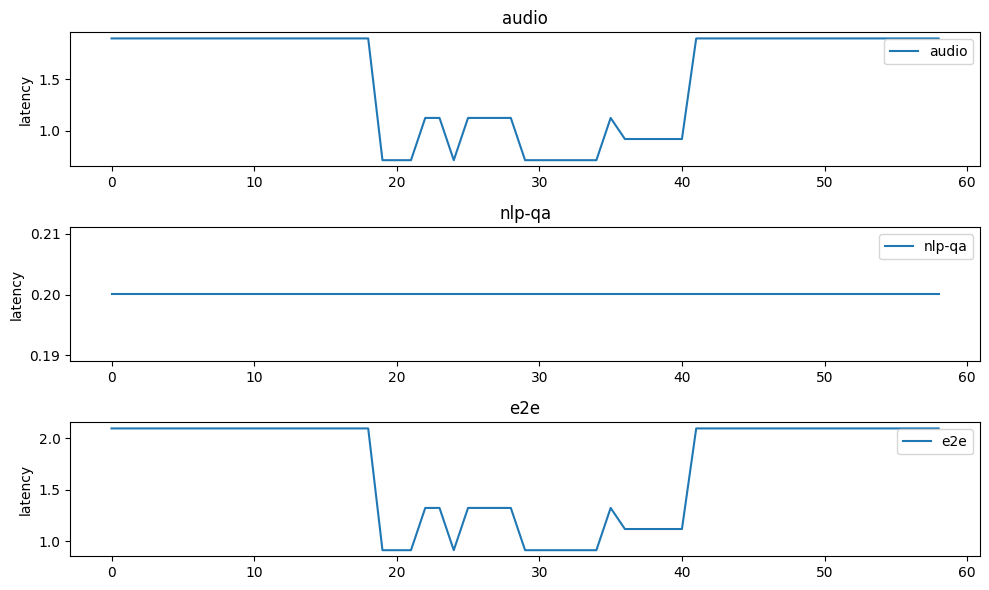

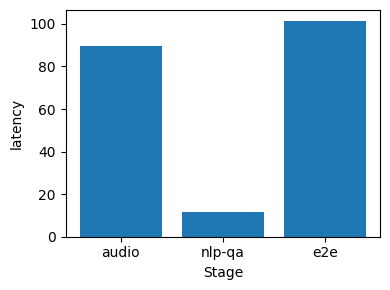

In [73]:
latency_changes = {}
nodes = []
for node_name, metrics in series_changes["nodes"].items():
    latency_changes[node_name] = metrics["latency"]
    nodes.append(node_name)
# replica_changes['total'] = []
ylabel = "latency"
latency_changes["e2e"] = [sum(x) for x in zip(*latency_changes.values())]
draw_temporal(latency_changes, ylabel=ylabel)
draw_cumulative(latency_changes, ylabel=ylabel)

# Real Latencies

In [74]:
loader.loader.per_request_result_processing()
all_latencies = loader.loader.per_request_result_processing()
import numpy as np

# a = np.array(all_latencies['router_to_task_0_queue']) + np.array(all_latencies['task_0_queue_to_task_0'])
# all_latencies['test'] = a.tolist()
draw_temporal(all_latencies, ylabel=ylabel)

FileNotFoundError: [Errno 2] No such file or directory: '/home/cc/infernece-pipeline-joint-optimization/data/results/final/series/430/0.json'

In [ ]:
if not simulation_mode:
    timeout_per_second, per_second_results = loader.per_second_result_processing()

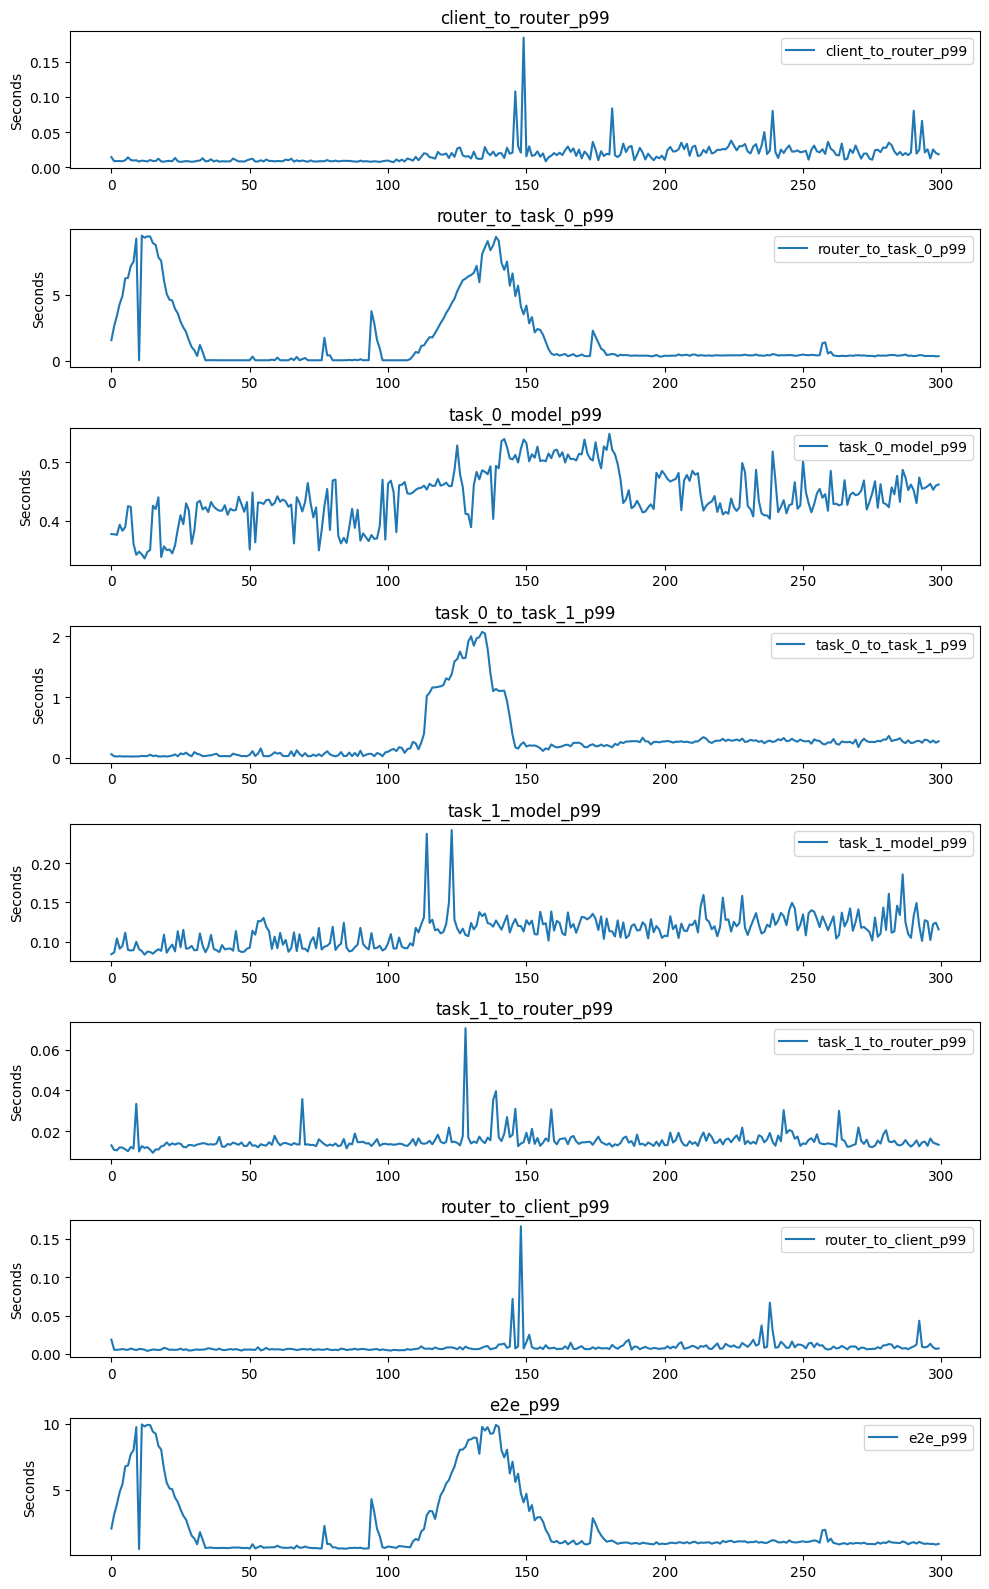

In [ ]:
mode = "p99"
if not simulation_mode:
    p99_cols = list(filter(lambda col: mode in col, per_second_results.columns))
    p99_all = per_second_results[p99_cols]  # [1400:]
    # p99_all_without_e2e = p99_all.drop([f"e2e_{mode}", f"former_router_to_task_0_{mode}"], axis=1)
    # p99_all["p99_e2e_synthetic"] = p99_all_without_e2e.sum(axis=1).to_list()
    # p99_all["p99_e2e_synthetic"] = p99_all.sum(axis=1).to_list()
    ylabel = "Seconds"
    # p99_all['mine'] = p99_all['router_to_task_0_queue_latencies_p99'] + p99_all['task_0_queue_to_task_0_p99']
    draw_temporal(p99_all.to_dict(orient="list"), ylabel=ylabel)
    # draw_cumulative()

# Every point a change was triggered

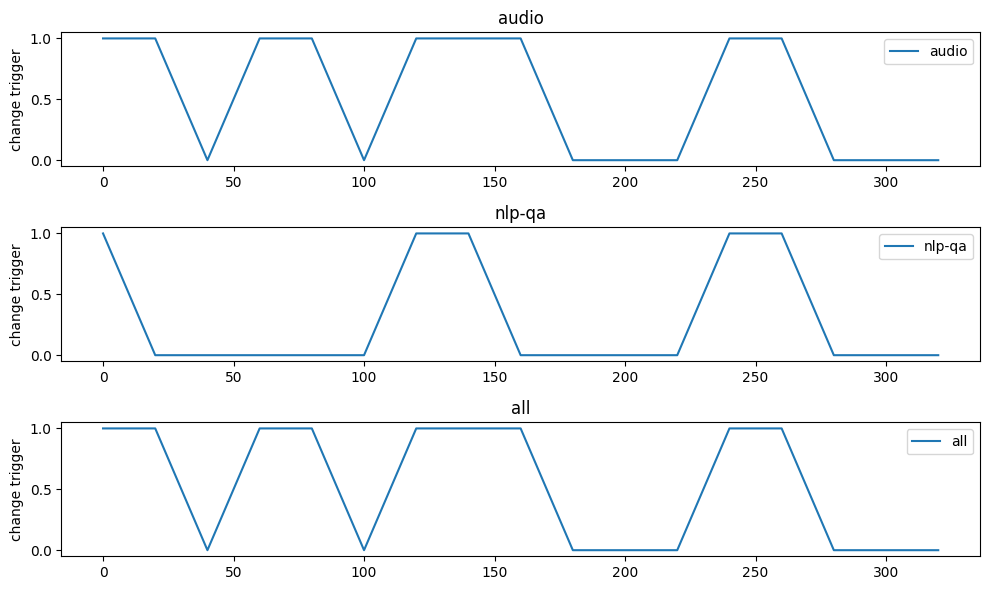

In [ ]:
series_changes.keys()
change_trigger = loader.points_with_change(adaptation_log=adaptation_log)
change_trigger["all"] = [any(x) for x in zip(*change_trigger.values())]
ylabel = "change trigger"
draw_temporal(change_trigger, adaptation_interval=adaptation_interval, ylabel=ylabel)

# Changes in the objective

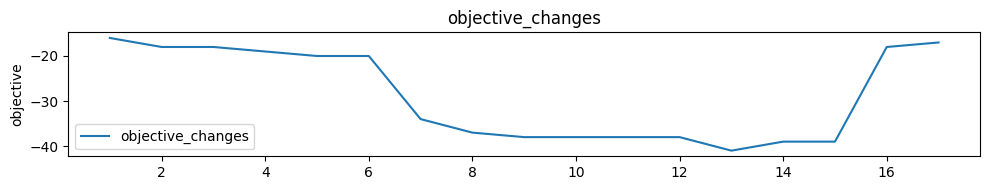

In [ ]:
objective_changes = series_changes["objective"]
objective_changes = {"objective_changes": objective_changes}
ylabel = "objective"
draw_temporal(objective_changes, ylabel=ylabel)

## Config Change

In [ ]:
# TODO sent load -> extract the sent date from twitter trace and also from the recived load on the server
# TODO model ranks/accuracies -> 1. load accuracy scores 2. start with Mehran but go rank based
# TODO model CPU usgages
# TODO SLA violations
# TODO

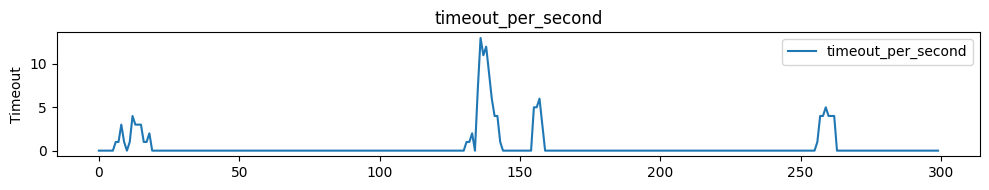

140 out of 6103


In [ ]:
ylabel = "Timeout"
if not simulation_mode:
    timeout_dics = {"timeout_per_second": timeout_per_second}
    draw_temporal(timeout_dics, ylabel=ylabel)
    print(f"{sum(timeout_per_second)} out of {sum(sent_load)}")

In [ ]:
for key, value in series_changes.items():
    if key == "nodes":
        for node_name, all_configs in value.items():
            print(f"node: {node_name}\n")
            for config_name, config_values in all_configs.items():
                print(f"{config_name}: {config_values}")

node: audio

cpu: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
replicas: [1, 4, 6, 6, 7, 8, 8, 19, 21, 22, 22, 22, 22, 24, 23, 23, 23, 23]
batch: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
variant: ['facebook-s2t-small-librispeech-asr', 'facebook-s2t-small-librispeech-asr', 'facebook-s2t-small-librispeech-asr', 'facebook-s2t-small-librispeech-asr', 'facebook-s2t-small-librispeech-asr', 'facebook-s2t-small-librispeech-asr', 'facebook-s2t-small-librispeech-asr', 'facebook-s2t-small-librispeech-asr', 'facebook-s2t-small-librispeech-asr', 'facebook-s2t-small-librispeech-asr', 'facebook-s2t-small-librispeech-asr', 'facebook-s2t-small-librispeech-asr', 'facebook-s2t-small-librispeech-asr', 'facebook-s2t-small-librispeech-asr', 'facebook-s2t-small-librispeech-asr', 'facebook-s2t-small-librispeech-asr', 'facebook-s2t-small-librispeech-asr', 'facebook-s2t-small-librispeech-asr']
latency: [0.7126765584945679, 0.7126765584945679, 0.7126765584945679, 0.7126765584945679, 0.712

In [ ]:
yolo = pd.DataFrame(series_changes["nodes"]["yolo"])
resnet_human = pd.DataFrame(series_changes["nodes"]["resnet-human"])

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/cc/miniconda3/envs/central/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_2795242/2878837397.py", line 1, in <module>
    yolo = pd.DataFrame(series_changes["nodes"]["yolo"])
KeyError: 'yolo'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/cc/miniconda3/envs/central/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2105, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/home/cc/miniconda3/envs/central/lib/python3.9/site-packages/IPython/core/ultratb.py", line 1428, in structured_traceback
    return FormattedTB.structured_traceback(
  File "/home/cc/miniconda3/envs/central/lib/python3.9/site-packages/IPython/core/ultratb.py", line 1319, in structured_traceback
    return VerboseTB.structured_traceback(
  File 

In [ ]:
yolo[yolo["throughput"] > 56]

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/cc/miniconda3/envs/central/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_2795242/241634920.py", line 1, in <module>
    yolo[yolo["throughput"] > 56]
NameError: name 'yolo' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/cc/miniconda3/envs/central/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2105, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/home/cc/miniconda3/envs/central/lib/python3.9/site-packages/IPython/core/ultratb.py", line 1428, in structured_traceback
    return FormattedTB.structured_traceback(
  File "/home/cc/miniconda3/envs/central/lib/python3.9/site-packages/IPython/core/ultratb.py", line 1319, in structured_traceback
    return VerboseTB.structured_traceback(
  File "/h

In [ ]:
resnet_human[resnet_human["throughput"] > 48]

NameError: name 'resnet_human' is not defined